## CS6700 PA3 - Options

`Authors: Aditya C (CS20B003), Kruthic Vignesh (CS20B045)`

### Imports and Config

In [463]:
import numpy as np
from tqdm import tqdm
import random

import gymnasium as gym

import matplotlib.pyplot as plt
import seaborn as sns

In [464]:
""" Learning parameters """

GAMMA = 1
ALPHA = 0.5

""" Locations of marked states in the Taxi-v3 environment """

env = gym.make("Taxi-v3")
RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC = map(
    lambda x: x[0] * 5 + x[1], env.unwrapped.locs
)
env.close()

""" Constants for the Taxi-v3 environment """
GRID_SIZE = 25
N_PRIMITIVE_MOVES = 4
N_PRIMITIVE_ACTIONS = N_PRIMITIVE_MOVES + 2
N_OPTIONS = 4
N_TOTAL_ACTIONS = N_PRIMITIVE_ACTIONS + N_OPTIONS

### Action Selection: $\epsilon$-greedy policy

In [465]:
def epsilonGreedyPolicy(q_value_arr, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, len(q_value_arr) - 1)
    else:
        return np.argmax(q_value_arr)

### Options Framework

In [466]:
class Option:

    def __init__(
        self,
        num_positions: int,
        num_actions: int,
        terminal_position: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_value = np.zeros((num_positions, num_actions))
        self.terminal_position = terminal_position
        self.gamma = gamma
        self.alpha = alpha

    def state_to_position(self, state: int):
        return state // 20

    def get_action(self, state: int, epsilon: float = 0.1):
        """
        - state: int, the current state (0 - 499)
        - epsilon: float, the probability of selecting a random action
        """

        # The state is converted to a position in the grid since the option is agnostic to the destination and passenger locations.
        position = self.state_to_position(state)
        return epsilonGreedyPolicy(self.q_value[position], epsilon)

    def q_update(self, state: int, action: int, reward: float, next_state: int):
        """Update the Q-value of the option using the Q-learning update rule."""
        position = self.state_to_position(state)
        next_position = self.state_to_position(next_state)
        self.q_value[position, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_value[next_position])
            - self.q_value[position, action]
        )

    def check_done(self, state: int):
        """The option terminates if the agent reaches terminal position."""
        return self.state_to_position(state) == self.terminal_position

### Hierarchical Reinforcement Learning

- In HRL, we look at the problem as a hierarchy of tasks. 

- The high-level policy selects a subgoal, and the low-level policy tries to achieve that subgoal. 

- The high-level policy is trained using the options framework & Q-learning, and the low-level policy is trained using the Q-learning algorithm.

In [467]:
class HRL_Agent:

    def __init__(
        self,
        state_size: int,
        action_size: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_values = np.zeros((state_size, action_size))
        self.update_freq = np.zeros((state_size, action_size))
        self.gamma = gamma
        self.alpha = alpha
        self.options = []
        for loc in [RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC]:
            self.options.append(Option(25, 4, loc))

    def update_primitive(self, state: int, action: int, reward: float, next_state: int):
        """Update the Q-value of the primitive action using the Q-learning update rule."""
        self.q_values[state, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [468]:
class SMDP_Agent(HRL_Agent):

    def __init__(self, state_size, action_size, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, gamma, alpha)

    def update_option_midway(self, *args, **kwargs):
        return

    def update_option_once(
        self, state: int, action: int, reward: float, next_state: int, opt_duration: int
    ):
        self.q_values[state, action] += self.alpha * (
            reward
            + (self.gamma**opt_duration) * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [469]:
class IntraOption_Q_Learning(HRL_Agent):

    def __init__(self, state_size, action_size, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, gamma, alpha)

    def update_option_midway(
        self,
        option: int,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool,
    ):
        self.update_primitive(state, action, reward, next_state)
        next_val = (
            done * np.max(self.q_values[next_state])
            + (1 - done) * self.q_values[next_state, option]
        )
        if done == True and next_state // 20 == 0 and option == 6:
            print(f"done. next_state: {next_state}, next_val: {next_val}")
        self.q_values[state, option] += self.alpha * (
            reward + self.gamma * next_val - self.q_values[state, option]
        )
        self.update_freq[state, option] += 1

    def update_option_once(self, *args, **kwargs):
        return

In [470]:
class Trainer:

    def __init__(self, env, hrl):
        self.env = env
        self.hrl = hrl
        self.scores_arr = []

    def train(self, num_episodes: int = 1000):

        self.scores_arr = []
        epsilon = 0.1

        for episode in tqdm(range(num_episodes)):

            state, _ = self.env.reset()
            done = False
            total_reward = 0

            epsilon = max(0.01, epsilon * 0.9975)

            # while episode is not over
            while not done:

                # choose action
                arr = self.hrl.q_values[state][4:]
                action = epsilonGreedyPolicy(arr, epsilon=epsilon) + 4
                # action = epsilonGreedyPolicy(self.hrl.q_values[state])

                """ Primitive actions - South, North, East, West, Pickup, Dropoff """
                if action < 6:
                    next_state, reward, is_terminal, is_trunc, _ = self.env.step(action)
                    done = is_terminal or is_trunc
                    total_reward += reward
                    self.hrl.update_primitive(state, action, reward, next_state)
                    state = next_state

                else:
                    """ Options - Go to Red, Green, Yellow, Blue """
                    opt_start_state, opt_id = state, action - 6
                    Option = self.hrl.options[opt_id]
                    opt_start_state = state
                    opt_reward, opt_duration, opt_done = 0, 0, Option.check_done(state)
                    opt_action_list = []

                    if opt_done:
                        continue
                        
                    """ Execute option """
                    while not opt_done and not done:

                        # choose action
                        opt_action = Option.get_action(state, epsilon=epsilon)
                        opt_action_list.append(opt_action)

                        # take action
                        next_state, reward, is_terminal, is_trunc, _ = self.env.step(opt_action)
                        done = is_terminal or is_trunc
                        total_reward += reward
                        opt_reward += reward * (self.hrl.gamma**opt_duration)

                        # update option's q-values
                        Option.q_update(state, opt_action, reward, next_state)
                        
                        # update q-values of hrl
                        opt_done = Option.check_done(next_state)
                        self.hrl.update_option_midway(
                                action, state, opt_action, reward, next_state, (done or opt_done)
                        )

                        # update variables
                        opt_duration += 1
                        state = next_state

                    """ End of option - update q-values """
                    # for SMDP Q-Learning
                    self.hrl.update_option_once(
                        opt_start_state, action, opt_reward, next_state, opt_duration
                    )

                """ If episode is over, append total reward """
                if done:
                    self.scores_arr.append(total_reward)

                # if done and ep % 10 == 0:
                #     print("\rEpisodes: {}, Average Reward: {}".format(episode, np.mean(self.scores_arr[-10:])))

        # aggregate every 5 elements for smoother plot
        scores_arr = np.array(self.scores_arr)
        scores_arr = scores_arr[: len(scores_arr) // 5 * 5].reshape(
            -1, 5
        )
        scores_arr = scores_arr.mean(axis=1)

        plt.figure(figsize=(10, 5))
        plt.plot(scores_arr)
        print(np.max(self.scores_arr), np.min(self.scores_arr))

  2%|▏         | 17/1000 [00:00<00:06, 162.90it/s]

done. next_state: 2, next_val: 0.0
done. next_state: 11, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 2, next_val: 0.0
done. next_state: 1, next_val: 0.0
done. next_state: 1, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 19, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 18, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 1, next_val: 0.0
done. next_state: 1, next_val: 0.0
done. next_state: 8, next_val: 0.0
done. next_state: 8, next_val: 0.0
done. next_state: 8, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 19, next_val: 0.0
done. next

  5%|▌         | 52/1000 [00:00<00:05, 164.11it/s]

done. next_state: 9, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 9, next_val: 0.0
done. next_state: 17, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 16, next_val: 15.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 18, next_val: 0.0
done. next_state: 18, next_val: 0.0
done. next_state: 2, next_val: 0.0
done. next_state: 2, next_val: 0.0
done. next_state: 1, next_val: 0.0
done. ne

 10%|█         | 101/1000 [00:00<00:04, 212.65it/s]

done. next_state: 7, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 19, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 18, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 17, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done

 16%|█▌        | 157/1000 [00:00<00:03, 250.99it/s]

done. next_state: 13, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 17, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 7, next_val: 0.0
done. next_state: 19, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 2, next_val: 0.0
done. next_state: 2, next_val: 0.0
done. next_state: 2, next_val: 0.0
done. next_state: 11, next_val: 0.0
done. next_state: 19, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 3, next_val: 0.0
done. next_state: 11, next_val: 0.0
done. next_state: 11, next_val: 0.0
done. next_state: 11, next_val: 0.0
done. next_state: 11, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. ne

 23%|██▎       | 229/1000 [00:00<00:02, 304.35it/s]

done. next_state: 16, next_val: 19.999999999417923
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 2, next_val: 6.392542839050293
done. next_state: 1, next_val: 1.0705727346994536
done. next_state: 2, next_val: 9.314659595489502
done. next_state: 11, next_val: 1.7864456481280124
done. next_state: 11, next_val: 2.4922961931851946
done. next_state: 7, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 12, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 18, next_val: 15.034735083580017
done. next_state: 2, next_val: 12.341001212596893
done. next_state: 1, next_val: 2.1142742625461324
done. next_state: 6, next_val: 0.0
done. next_st

 29%|██▉       | 294/1000 [00:01<00:02, 310.92it/s]

done. next_state: 12, next_val: 4.119144975772439
done. next_state: 16, next_val: 20.0
done. next_state: 12, next_val: 4.163881968620969
done. next_state: 16, next_val: 20.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 3, next_val: 11.680666183810388
done. next_state: 11, next_val: 6.95646628641593
done. next_state: 11, next_val: 7.171191274291335
done. next_state: 7, next_val: 1.4275273618001434
done. next_state: 7, next_val: 1.7064124168483672
done. next_state: 7, next_val: 2.167611236989039
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 16, next_val: 20.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 16, next_val: 20.0
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val

 37%|███▋      | 374/1000 [00:01<00:01, 351.40it/s]

done. next_state: 16, next_val: 20.0
done. next_state: 1, next_val: 10.99589541188352
done. next_state: 16, next_val: 20.0
done. next_state: 2, next_val: 14.995638144489476
done. next_state: 14, next_val: 0.0
done. next_state: 14, next_val: 0.0
done. next_state: 18, next_val: 15.999969694100884
done. next_state: 16, next_val: 20.0
done. next_state: 19, next_val: 12.968509396380117
done. next_state: 3, next_val: 11.968509391548476
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 16, next_val: 20.0
done. next_state: 11, next_val: 7.892129569190132
done. next_state: 11, next_val: 7.923315302429339
done. next_state: 19, next_val: 12.968509396380117
done. next_state: 1, next_val: 10.997479348146333
done. next_state: 1, next_val: 10.998414297256108
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 4, next_val: 0.0
done. next_state: 8, next_val: 3.

 46%|████▌     | 461/1000 [00:01<00:01, 397.88it/s]

done. next_state: 7, next_val: 5.1318077461615905
done. next_state: 19, next_val: 12.998808490519059
done. next_state: 11, next_val: 7.98799452279601
done. next_state: 12, next_val: 4.641480501081983
done. next_state: 16, next_val: 20.0
done. next_state: 11, next_val: 7.992482169763988
done. next_state: 11, next_val: 7.99521463849694
done. next_state: 6, next_val: 0.0
done. next_state: 6, next_val: 0.0
done. next_state: 1, next_val: 10.999832480308728
done. next_state: 1, next_val: 10.999906646872013
done. next_state: 3, next_val: 11.998808490519057
done. next_state: 3, next_val: 11.998808490519057
done. next_state: 14, next_val: 0.8402356725444196
done. next_state: 14, next_val: 1.0762658769126625
done. next_state: 14, next_val: 1.2292335021187464
done. next_state: 16, next_val: 20.0
done. next_state: 13, next_val: 0.0
done. next_state: 13, next_val: 0.0
done. next_state: 13, next_val: 0.2402935857946591
done. next_state: 13, next_val: 1.5287326725813501
done. next_state: 13, next_val

 58%|█████▊    | 585/1000 [00:01<00:00, 507.37it/s]

done. next_state: 9, next_val: 6.779161605131874
done. next_state: 9, next_val: 6.870564659041454
done. next_state: 9, next_val: 6.9244681509865345
done. next_state: 8, next_val: 10.512975983702226
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 3, next_val: 11.999597707772569
done. next_state: 11, next_val: 7.996904674110349
done. next_state: 19, next_val: 12.999848709048916
done. next_state: 3, next_val: 11.99984715384914
done. next_state: 3, next_val: 11.99991077274532
done. next_state: 3, next_val: 11.999948205969488
done. next_state: 1, next_val: 10.999996764884298
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 6, next_val: 0.0
done. next_state: 18, next_val: 15.999999999188727
done. next_state: 4, next_val: 2.1856995393960323
done. next_state: 16, next_val: 20.0
done. next_state: 1, next_val: 10.999997499080887
done. next_state: 1, next_val: 10.99999894550741
done. next_state: 16, next_val: 2

 73%|███████▎  | 732/1000 [00:01<00:00, 614.71it/s]

done. next_state: 19, next_val: 12.999999753905783
done. next_state: 9, next_val: 6.997287501922516
done. next_state: 4, next_val: 2.412763386340452
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 1, next_val: 10.999999850193209
done. next_state: 3, next_val: 11.999999753905783
done. next_state: 3, next_val: 11.999999753905783
done. next_state: 3, next_val: 11.999999753905783
done. next_state: 2, next_val: 14.99999999993219
done. next_state: 16, next_val: 20.0
done. next_state: 1, next_val: 10.999999921432561
done. next_state: 1, next_val: 10.999999921432561
done. next_state: 1, next_val: 10.999999921432561
done. next_state: 16, next_val: 20.0
done. next_state: 8, next_val: 10.966648472522024
done. next_state: 16, next_val: 20.0
done. next_state: 2, next_val: 14.999999999966093
done. next_state: 1, next_val: 10.999999921432561
done. next_state: 8, next_val: 10.983116197260859
done. next_state: 16, next_val

100%|██████████| 1000/1000 [00:02<00:00, 449.61it/s]

done. next_state: 7, next_val: 5.9794786776813575
done. next_state: 2, next_val: 15.0
done. next_state: 16, next_val: 20.0
done. next_state: 7, next_val: 5.988485127941457
done. next_state: 1, next_val: 10.999999999655744
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 1, next_val: 10.999999999766693
done. next_state: 6, next_val: 2.6364229011616898
done. next_state: 1, next_val: 10.999999999851617
done. next_state: 3, next_val: 11.999999994630775
done. next_state: 1, next_val: 10.999999999909374
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 3, next_val: 11.999999997188386
done. next_state: 16, next_val: 20.0
done. next_state: 2, next_val: 15.0
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 2, next_val: 15.0
done. next_state: 16, next_val: 20.0
done. next_state: 16, next_val: 20.0
done. next_state: 3, next_val: 11.99999999853069
done. next_state: 3, nex

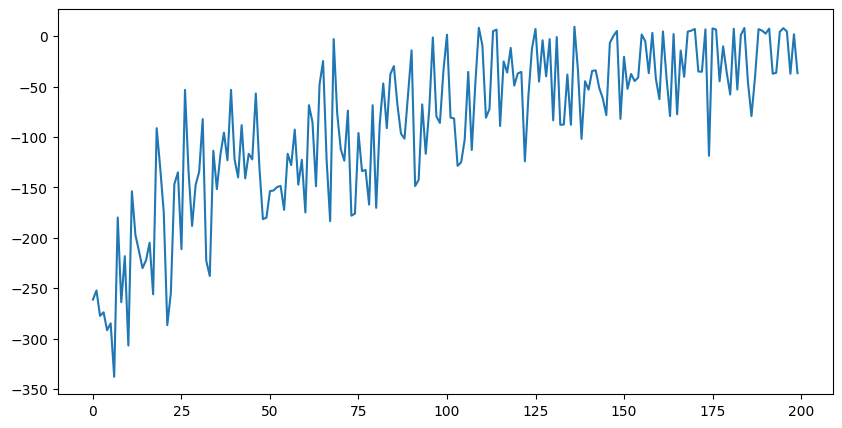

In [471]:
# agent = SMDP_QLearning(500, 10)
agent = IntraOption_Q_Learning(500, 10)
trainer = Trainer(env, agent)
trainer.train(1000)

<Axes: >

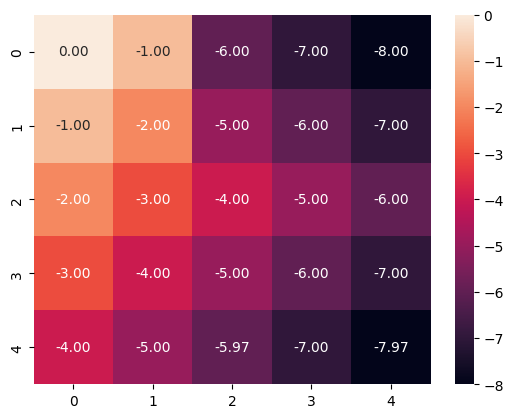

In [472]:
red_grid = agent.options[0].q_value.max(axis=1).reshape(5, 5)  
sns.heatmap(red_grid, annot=True, fmt=".2f")

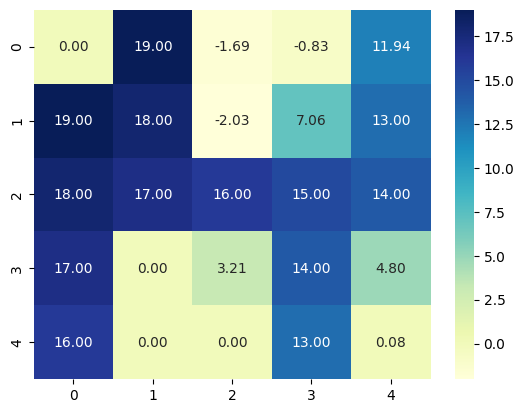

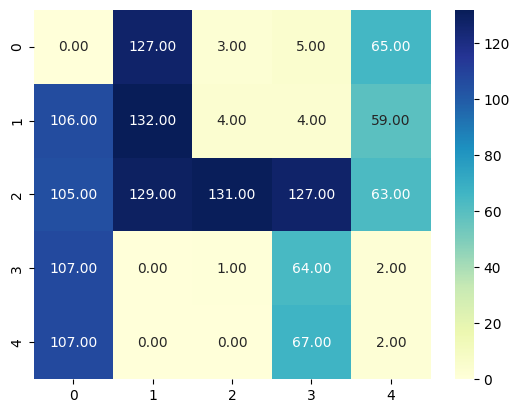

In [473]:
# select every 4th row of q_values and put it into a grid

# desination fixed to be red
grid = agent.q_values[::4]
grid2 = agent.update_freq[::4]

# passenger is inside car
grid = grid[4::5]
grid2 = grid2[4::5]

grid = grid[:,6].reshape(5,5)
grid2 = grid2[:,6].reshape(5,5)

# plot the grid
sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

sns.heatmap(grid2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

In [474]:
st = (0 * 5 + 4) * 4 + 0
trainer.hrl.q_values[st]

array([16.87491985,  0.        ,  0.        ,  0.        ,  9.02339935,
       20.        ,  0.        , -0.75      , -0.5       , -1.        ])